<a href="https://colab.research.google.com/github/melikesifa/predictions/blob/main/task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color='#475468'> Melbourne House Prices:</font>
### <font color='#475468'> Can you leverage more columns in the data set for better predictions?</font>

## Initialize

In [3]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')

print(df.head())

   User_ID Product_ID Gender   Age  Occupation City_Category  \
0  1000001  P00069042      F  0-17          10             A   
1  1000001  P00248942      F  0-17          10             A   
2  1000001  P00087842      F  0-17          10             A   
3  1000001  P00085442      F  0-17          10             A   
4  1000002  P00285442      M   55+          16             C   

  Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
0                          2               0                   3   
1                          2               0                   1   
2                          2               0                  12   
3                          2               0                  12   
4                         4+               0                   8   

   Product_Category_2  Product_Category_3  Purchase  
0                 NaN                 NaN      8370  
1                 6.0                14.0     15200  
2                 NaN                 NaN   

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


There is too little data for catagory 3. So the predictions  for that catagory may not be totally accurate

In [7]:
# Select target as a series and features as dataframe
y = df.loc[:,['Purchase']].values.ravel()
X = df.drop(['Purchase'],axis=1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, test_size=0.2,random_state=1)

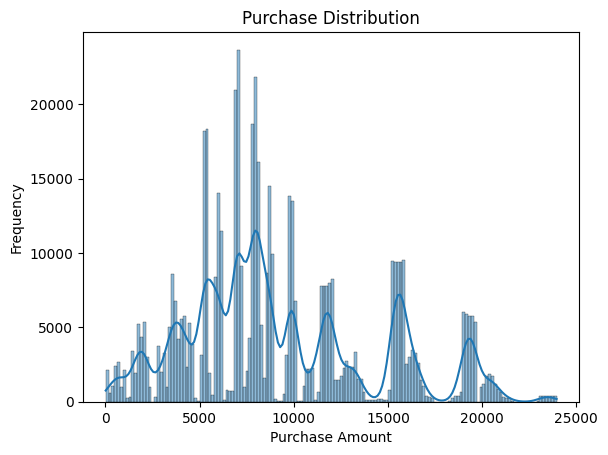

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df['Purchase'], kde=True)
plt.title('Purchase Distribution')
plt.xlabel('Purchase Amount')
plt.ylabel('Frequency')
plt.show()


It is multimodel. There are common purchase amounts that occur more frequently.


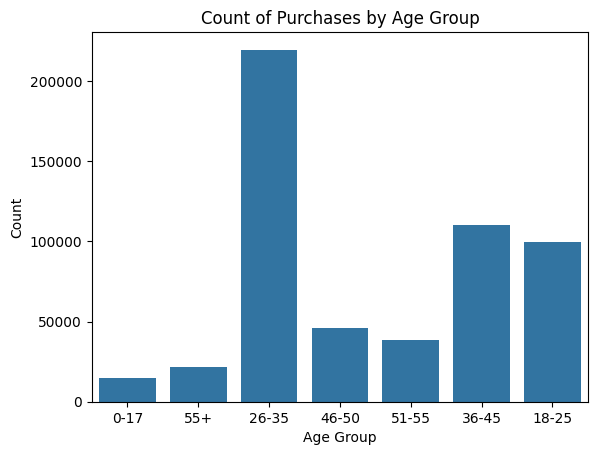

In [30]:
sns.countplot(x='Age', data=df)
plt.title('Count of Purchases by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

## Build Random Forest Model

In [8]:
from sklearn.ensemble import RandomForestRegressor

# Function for building and scoring Random Forest models
def get_random_forest_mae(X_trn, X_tst, y_trn, y_tst):
    mdlRfs = RandomForestRegressor(random_state=1)
    mdlRfs.fit(X_trn, y_trn)
    y_tst_prd = mdlRfs.predict(X_tst)
    mae = mean_absolute_error(y_tst, y_tst_prd)
    return (mae)

In [9]:
# Select numeric features
cols_num = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
Xnum = X[cols_num]

# Split numeric features into training and test sets
Xnum_train, Xnum_test, y_train, y_test = train_test_split(Xnum,y,train_size=0.8, test_size=0.2,random_state=1)

In [10]:
# Count number of missing values in each column of the training data
Xnum_train.isna().sum()

User_ID                    0
Occupation                 0
Marital_Status             0
Product_Category_1         0
Product_Category_2    138892
Product_Category_3    306504
dtype: int64

In [11]:
# Identify columns with missing values and then drop such columns
cols_num_null = [col for col in Xnum_train.columns
    if Xnum_train[col].isnull().any()]
Xnum_train_drpnull = Xnum_train.drop(cols_num_null, axis=1)
Xnum_test_drpnull = Xnum_test.drop(cols_num_null, axis=1)

In [12]:
print('MAE from Approach 1 (Drop features with missing values):')
print(get_random_forest_mae(Xnum_train_drpnull, Xnum_test_drpnull, y_train, y_test))

MAE from Approach 1 (Drop features with missing values):
2091.2402741391948


## Non-numerical Features

We have already seen the error generated by non-numeric features, but let's try to convert them to numeric values so that they can be used in the model.

In [13]:
cols_obj = [col for col in X_train.columns if X_train[col].dtype == 'object']

# Append 'Other' to each categorical column in the training data before fitting the encoder
for col in cols_obj:
    extended_col = pd.concat([X_train[col], pd.Series(['Other'])])  # Append 'Other'
    label_encoder = LabelEncoder()
    label_encoder.fit(extended_col)  # Fit including 'Other'

    # Now transform the train and test datasets
    X_train[col] = label_encoder.transform(X_train[col])

    # Replace unseen categories in the test set with 'Other' and transform
    X_test[col] = X_test[col].apply(lambda x: x if x in label_encoder.classes_ else 'Other')
    X_test[col] = label_encoder.transform(X_test[col])

In [14]:
print("Transformed training data sample:")
print(X_train[cols_obj].head())

print("\nTransformed testing data sample:")
print(X_test[cols_obj].head())

Transformed training data sample:
        Product_ID  Gender  Age  City_Category  Stay_In_Current_City_Years
529969        2890       1    1              1                           1
489075        2281       1    3              2                           1
60693         1068       1    1              0                           0
381752        1365       1    2              1                           3
141968        1970       1    2              0                           0

Transformed testing data sample:
        Product_ID  Gender  Age  City_Category  Stay_In_Current_City_Years
470060          25       1    2              2                           0
395974          34       1    5              0                           2
14234         1095       0    1              0                           3
72183         1657       1    2              1                           1
272536        1970       0    2              0                           0


There are too many values to be label encoded.  So, we would need to take only those non-numeric features with low cardinality aka **Categorical features**.

In [15]:
# Select categorical features
cols_cat = [col for col in X.columns if X[col].dtype == 'object' and X[col].nunique()<10]
cols_cat

['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years']

In [16]:
# Label encoding on only categorical features
from sklearn.preprocessing import LabelEncoder

Xle_train = X_train.copy()
Xle_test = X_test.copy()
# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in cols_cat:
    Xle_train[col] = label_encoder.fit_transform(X_train[col])
    Xle_test[col] = label_encoder.transform(X_test[col])

In [22]:
Xle_train['Product_Category_2'].fillna(-1, inplace=True)
Xle_train['Product_Category_3'].fillna(-1, inplace=True)
Xle_test['Product_Category_2'].fillna(-1, inplace=True)
Xle_test['Product_Category_3'].fillna(-1, inplace=True)

I had to remove NaN inputs. Otherwise it wasnt possible to get random forest model results.

In [23]:
# Encode and Build/Score using all Categorical columns

mae = get_random_forest_mae(Xle_train[cols_num + cols_cat], Xle_test[cols_num + cols_cat], y_train, y_test)
print("MAE from Label Encoding all Categorical columns:")
print(mae)

MAE from Label Encoding all Categorical columns:
2155.664667014182


So, by including the Categorical features, the MAE is further reduced to to \$166K (which translates to 15% off a mean price of \$1.1M), which is by far the best result.

## Build Gradient Boosted Tree Model

In [24]:
from xgboost import XGBRegressor

#Build and score default Gradient Boosting Model
mdlXgbMlb = XGBRegressor()
mdlXgbMlb.fit(Xle_train[cols_num + cols_cat], y_train)
y_test_pred = mdlXgbMlb.predict(Xle_test[cols_num + cols_cat])
mae = mean_absolute_error(y_test_pred, y_test)

print("MAE from default XGBoost model:")
print(mae)

MAE from default XGBoost model:
2088.5694435910577


In [25]:
#Build and score a tuned Gradient Boosting Model
mdlXgbMlb = XGBRegressor(n_estimators=5000, learning_rate=0.01, max_depth=5)
mdlXgbMlb.fit(Xle_train[cols_num + cols_cat], y_train)
y_test_pred = mdlXgbMlb.predict(Xle_test[cols_num + cols_cat])
mae = mean_absolute_error(y_test_pred, y_test)

print("MAE from tuned XGBoost model:")
print(mae)

MAE from tuned XGBoost model:
2097.5185122484345
